In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from livelossplot.tf_keras import PlotLossesCallback
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split


import pickle

import numpy as np
import pandas as pd
from datetime import datetime 
import multiprocessing
import re
from bs4 import BeautifulSoup as bs
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import matplotlib.pyplot as plt

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings("ignore") #, category=np.VisibleDeprecationWarning)

print(tf.__version__)

2.12.0


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# data = pd.read_csv('../datasets/spam.csv', encoding="cp1251", usecols=['v1', 'v2'])
# data.head()   

In [4]:
#READ DATA
# def read_train_data():
#     data = pd.read_csv('../datasets/spam.csv', encoding="cp1251", usecols=['v1', 'v2'])
#     mapping = {'ham': 0, 'spam': 1}
#     data.replace({'v1': mapping}, inplace=True)
#     data.rename(columns={"v1": "labels"}, inplace=True)
#     data.rename(columns={"v2": "raw_text"}, inplace=True)
# #     data.drop(['violation'], axis=1, inplace=True)
#     print('Data size %d' % len(data))
#     print('Data headers %s' % data.columns.values)
#     return data

In [5]:
# data = read_train_data()

In [6]:
# data.head()

In [7]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(neurons, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.5)
        self.dropout2 = Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [8]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Preprocessing function

In [9]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
    text = bs(text,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    text = re.sub("[^a-zA-Z]"," ", text)
    
    # 3. Converting to lower case and splitting
    word_tokens = text.lower().split()
    
    # 4. Remove stopwords
    le = WordNetLemmatizer()
    stop_words = set(stopwords.words("english")+ ['14000kbps', 'november', '1080p', 'email', 
                                                 '4k', 'mp4', 'error', '404', '2022'])     
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review = " ".join(word_tokens)
    return cleaned_review

In [10]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [11]:
df_pos = pd.read_csv('../datasets/BadWordsService_ml_has_7days.csv')
df_neg =  pd.read_csv('../datasets/BadWordsService_ml_has_no_7days.csv')
df_val = pd.read_csv('../datasets/BadWordsService_ml_has_today.csv')

In [12]:
df_pos.drop('@timestamp', axis=1, inplace=True)
df_neg.drop('@timestamp', axis=1, inplace=True)
df_val.drop('@timestamp', axis=1, inplace=True)
df_val['ctxt_.time_spent'] = df_val['ctxt_.time_spent'] * 1000 # convert seconds to milliseconds

In [13]:
df_pos.rename(columns={"ctxt_.text": "raw_text", "ctxt_.time_spent": "time_spent_ms"}, inplace=True)
df_neg.rename(columns={"ctxt_.text": "raw_text", "ctxt_.time_spent": "time_spent_ms"}, inplace=True)
df_val.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
df_val.rename(columns={"ctxt_.time_spent": "time_spent_ms"}, inplace=True)

In [14]:
df_pos.head()

,time_spent_ms,raw_text
0,0.1,<p>A sexy gagged waitress is brought in the ro...
1,0.0,"DID, ASS GRABBING, GROPING DAMSEL IN DISTRESS"
2,0.0,"KICKING, CBT, AMATEUR, HIGH HEELS BALL ABUSE"
3,0.6,start\tend\ttext\n280\t260\tThere's another on...
4,0.5,"<p><img src=""http://www.astrodomina.com/mdm/im..."


In [15]:
df_neg.head()

,time_spent_ms,raw_text
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...
2,0.1,Wicked Chicks Show To Their Little Servant How...
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI..."
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ..."


In [16]:
df_val.head()

,time_spent_ms,raw_text
0,100.0,<p>SSBBW Ivy Davenport and I know just how wea...
1,4600.0,start\tend\ttext\n0\t19000\tAre you ready?\n19...
2,2500.0,start\tend\ttext\n0\t1900\tVery fun!\n4800\t70...
3,0.0,brunette creampie MV IWC C4S.mp4
4,5800.0,start\tend\ttext\n0\t10640\tSo I see someone's...


In [17]:
df_pos['labels'] = 1
df_neg['labels'] = 0

In [18]:
df_pos.head()

,time_spent_ms,raw_text,labels
0,0.1,<p>A sexy gagged waitress is brought in the ro...,1
1,0.0,"DID, ASS GRABBING, GROPING DAMSEL IN DISTRESS",1
2,0.0,"KICKING, CBT, AMATEUR, HIGH HEELS BALL ABUSE",1
3,0.6,start\tend\ttext\n280\t260\tThere's another on...,1
4,0.5,"<p><img src=""http://www.astrodomina.com/mdm/im...",1


In [19]:
df_neg.head()

,time_spent_ms,raw_text,labels
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...,0
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...,0
2,0.1,Wicked Chicks Show To Their Little Servant How...,0
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI...",0
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ...",0


In [20]:
df_val.head()

,time_spent_ms,raw_text
0,100.0,<p>SSBBW Ivy Davenport and I know just how wea...
1,4600.0,start\tend\ttext\n0\t19000\tAre you ready?\n19...
2,2500.0,start\tend\ttext\n0\t1900\tVery fun!\n4800\t70...
3,0.0,brunette creampie MV IWC C4S.mp4
4,5800.0,start\tend\ttext\n0\t10640\tSo I see someone's...


In [21]:
nan_values_neg = df_neg[df_neg.isna().any(axis=1)]
print(len(nan_values_neg))

# nan_values_pos = df_pos[df_pos.isna().any(axis=1)]
# print(len(nan_values_pos))

nan_values = df_val[df_val.isna().any(axis=1)]
print(len(nan_values))

221
0


In [22]:
df_neg.dropna(inplace=True)
df_neg.head()

,time_spent_ms,raw_text,labels
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...,0
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...,0
2,0.1,Wicked Chicks Show To Their Little Servant How...,0
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI...",0
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ...",0


In [23]:
df_pos['text'] = df_pos.apply(lambda row: clean_text(row.raw_text), axis=1)
df_neg['text'] = df_neg.apply(lambda row: clean_text(row.raw_text), axis=1)
df_val['text'] = df_val.apply(lambda row: clean_text(row.raw_text), axis=1)
# data['text'] = data.apply(lambda row: clean_text(row.raw_text), axis=1)

In [24]:
df_val.head()

,time_spent_ms,raw_text,text
0,100.0,<p>SSBBW Ivy Davenport and I know just how wea...,ssbbw ivy davenport know weak big bubbly fart ...
1,4600.0,start\tend\ttext\n0\t19000\tAre you ready?\n19...,start end text ready yeah okay name seth old s...
2,2500.0,start\tend\ttext\n0\t1900\tVery fun!\n4800\t70...,start end text fun nice show stuff okay good d...
3,0.0,brunette creampie MV IWC C4S.mp4,brunette creampie mv iwc c mp
4,5800.0,start\tend\ttext\n0\t10640\tSo I see someone's...,start end text see someone enjoying back home ...


In [25]:
# df = df_val[['text', 'labels']]

In [26]:
# df.head()

In [27]:
# df.labels.plot(kind='hist')

In [28]:
df_pos.drop('raw_text', axis=1, inplace=True)
df_neg.drop('raw_text', axis=1, inplace=True)
df_val.drop('raw_text', axis=1, inplace=True)

In [29]:
df_pos.shape, df_neg.shape, df_val.shape
# df.shape

((7746, 3), (31812, 3), (5255, 2))

In [30]:
df_tra = pd.concat([df_pos, df_neg], ignore_index=True)
df_tra.shape

(39558, 3)

In [31]:
df_tra.head()

,time_spent_ms,labels,text
0,0.1,1,sexy gagged waitress brought room masked man s...
1,0.0,1,as grabbing groping damsel distress
2,0.0,1,kicking cbt amateur high heel ball abuse
3,0.6,1,start end text another one erotic took side ri...
4,0.5,1,hd x p step mom help homework boner pant hangi...


In [32]:
df_val.head()

,time_spent_ms,text
0,100.0,ssbbw ivy davenport know weak big bubbly fart ...
1,4600.0,start end text ready yeah okay name seth old s...
2,2500.0,start end text fun nice show stuff okay good d...
3,0.0,brunette creampie mv iwc c mp
4,5800.0,start end text see someone enjoying back home ...


In [33]:
counter = counter_word(df_tra.text)  

In [34]:
counter

Counter({'sexy': 3084,
         'gagged': 1027,
         'waitress': 10,
         'brought': 239,
         'room': 1201,
         'masked': 68,
         'man': 1884,
         'sits': 307,
         'forcefully': 26,
         'straddle': 46,
         'couch': 399,
         'wrist': 224,
         'tied': 1360,
         'behind': 677,
         'back': 4841,
         'squeeze': 366,
         'hell': 250,
         'as': 11175,
         'thigh': 933,
         'toss': 52,
         'side': 1013,
         'tie': 669,
         'ankle': 530,
         'together': 790,
         'really': 4008,
         'manhandles': 3,
         'grope': 51,
         'shannon': 1,
         'helpless': 473,
         'struggling': 579,
         'grabbing': 233,
         'groping': 188,
         'damsel': 219,
         'distress': 156,
         'kicking': 484,
         'cbt': 947,
         'amateur': 463,
         'high': 2038,
         'heel': 2107,
         'ball': 3040,
         'abuse': 524,
         'start': 4775,


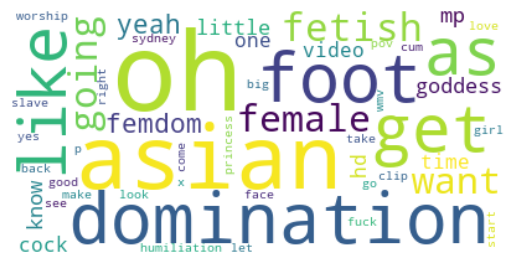

In [35]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [36]:
word_index =  dict()
for word, number in counter.items():
    word_index[word] = number + 3
    
word_index["<UNKNOWN>"] = 0
word_index["<FILLER>"] = 1
word_index["<BEGINOFSEQUENCE>"] = 2
word_index["<UNUSED>"] = 3

In [37]:
vocab_size = len(word_index)
oov_token = [k for k, v in word_index.items() if v == 0][0]
maxlen = 200

In [38]:
vocab_size

26586

In [39]:
from sklearn.utils import shuffle
RANDOM_STATE = 42

# df = shuffle(df, random_state=RANDOM_STATE).reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(df_tra.text.values, df_tra.labels.values, 
                                                  stratify=df_tra.labels.values, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size=0.2, shuffle=True)

In [40]:
print(len(X_train), "Training sequences")
print(len(X_val), "Validation sequences")

31646 Training sequences
7912 Validation sequences


In [41]:
y_val[:5]

array([0, 0, 0, 0, 1])

In [42]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df_tra.text.values)

# # saving
# with open('../models/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('../models/tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [43]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=maxlen)
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_sequences, maxlen=maxlen)

# Build Model

In [44]:
embed_dim = 50  # 50 Embedding size for each token 32
num_heads = 7  # Number of attention heads default value 2
neurons = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, num_heads, neurons)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x) # .35
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Metal device set to: Apple M2
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 50)          1339300   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_encoder (Transf  (None, 200, 50)          74582     
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         

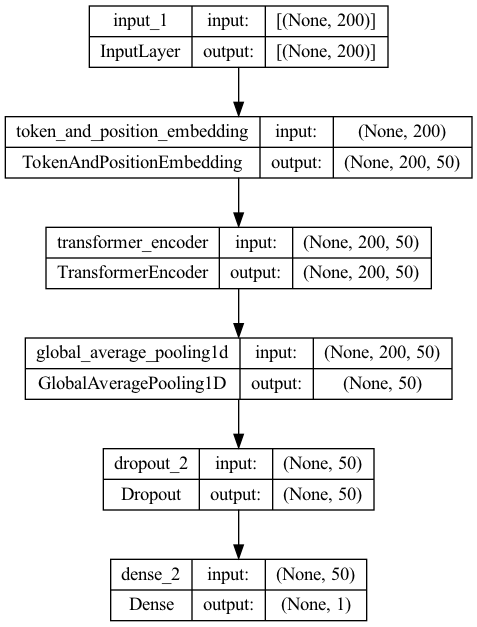

In [45]:
# draw model
tf.keras.utils.plot_model(model, show_shapes=True)

In [46]:
lr = 1e-5
epochs = 25

loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=lr) #.000001)
metrics = ['accuracy']

# metrics = [tf.keras.metrics.BinaryAccuracy(),
#            tf.keras.metrics.FalseNegatives(),
#            tf.keras.metrics.FalsePositives(),
#           ]

# from pathlib import Path

# path = Path('../models/bad_words/trans/')
# path.mkdir(exist_ok=True) 
# cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
# cpt_path = str(path / cpt_filename)

# checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=2, 
#                                                 save_best_only=True, mode='min')

# model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


# history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=32, validation_data=(X_val_padded, y_val), verbose=1, 
#            callbacks=[checkpoint, PlotLossesCallback()])
          
# # history = model.fit(X_train_padded, y_train, 
# #                     batch_size=64, epochs=10, 
# #                     validation_data=(X_val_padded, y_val)
#                    )

In [47]:
model_name = "../models/trans/trans_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train,
                    validation_data=(X_val_padded,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])
model.summary()

Epoch 1/25


2023-05-31 15:30:06.237511: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


989/989 [==============================] - 159s 159ms/step - loss: 0.2838 - accuracy: 0.8815 - val_loss: 0.1022 - val_accuracy: 0.9663
Epoch 2/25
989/989 [==============================] - 155s 157ms/step - loss: 0.0565 - accuracy: 0.9824 - val_loss: 0.0721 - val_accuracy: 0.9785
Epoch 3/25
989/989 [==============================] - 154s 156ms/step - loss: 0.0239 - accuracy: 0.9940 - val_loss: 0.0682 - val_accuracy: 0.9826
Epoch 4/25
989/989 [==============================] - 152s 154ms/step - loss: 0.0158 - accuracy: 0.9963 - val_loss: 0.0782 - val_accuracy: 0.9813
Epoch 4: early stopping
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 50)          1339300   
 g (TokenAndPositionEmbeddin                            

In [48]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.283765,0.881502,0.102159,0.966254
1,0.056451,0.982431,0.072076,0.978514
2,0.023946,0.993964,0.068156,0.982558
3,0.015751,0.996271,0.078221,0.981294


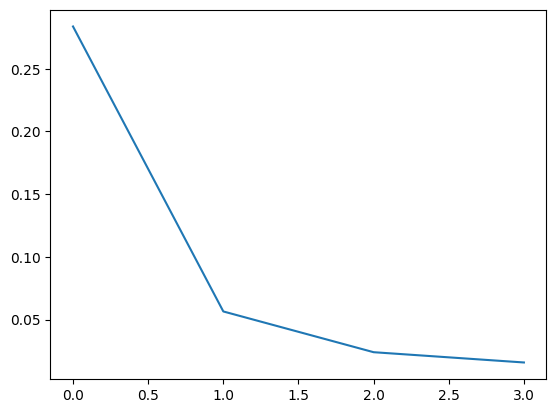

In [49]:
plt.plot(history_df.loss);

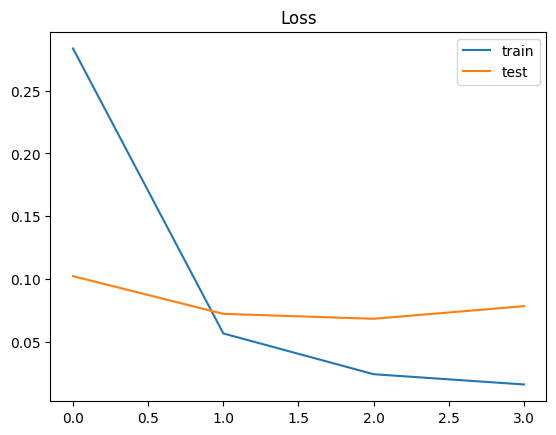

In [50]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

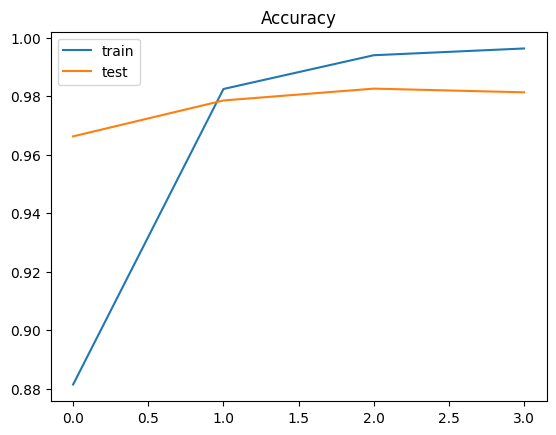

In [51]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

248/248 [==============================] - 14s 57ms/step


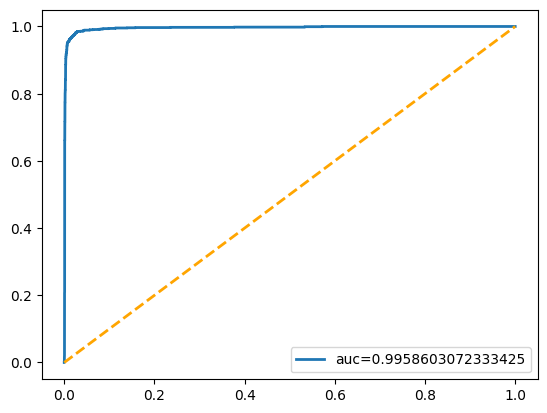

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

y_pred = model.predict(X_val_padded)
fpr, tpr, _ = roc_curve(y_val,  y_pred)
auc = roc_auc_score(y_val, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [53]:
y_pred = [1 if p > .5 else 0 for p in y_pred]

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6363
           1       0.94      0.97      0.95      1549

    accuracy                           0.98      7912
   macro avg       0.97      0.98      0.97      7912
weighted avg       0.98      0.98      0.98      7912



<Axes: >

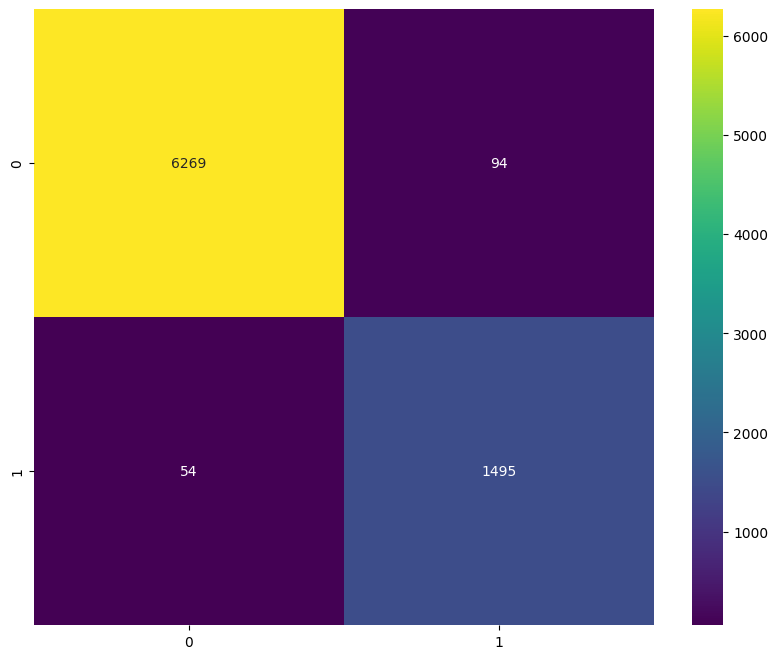

In [54]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_val, y_pred),annot=True,fmt='.4g',cmap='viridis')

In [55]:
results = model.evaluate(X_val_padded, y_val, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

248/248 - 14s - loss: 0.0782 - accuracy: 0.9813 - 14s/epoch - 57ms/step
loss: 0.078
accuracy: 0.981


In [56]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]
predictions

989/989 [==============================] - 56s 57ms/step


[0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [57]:
df_sequences = tokenizer.texts_to_sequences(df_tra.text)
df_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(df_sequences, maxlen=maxlen)

predictions = model.predict(df_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]
predictions

df_tra['predicted'] = predictions
df_tra = df_tra[['time_spent_ms', 'text', 'labels', 'predicted']]
df_tra.head()

1237/1237 [==============================] - 70s 57ms/step


,time_spent_ms,text,labels,predicted
0,0.1,sexy gagged waitress brought room masked man s...,1,1
1,0.0,as grabbing groping damsel distress,1,1
2,0.0,kicking cbt amateur high heel ball abuse,1,1
3,0.6,start end text another one erotic took side ri...,1,1
4,0.5,hd x p step mom help homework boner pant hangi...,1,1


In [58]:
df_tra.to_csv('../datasets/new_model.csv')

In [59]:
def roc_auc(predictions, target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [60]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

cock worship cock tease gay asian as fetish dick worship big black cock asian goddess asian princess femdom pov female supremacy femdom female domination domination humiliation verbal humiliation mind fuck
[22, 24, 22, 64, 438, 3, 8, 9, 71, 24, 46, 125, 22, 3, 15, 3, 38, 13, 27, 11, 77, 13, 11, 4, 4, 40, 459, 40, 60, 39]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0

In [61]:
# model.save_weights("../models/bpredict_class_weights.h5")
# model.load_weights("../models/bpredict_class_weights.h5") # loading weights - model had created erlier

In [62]:
# model = tf.keras.models.load_model("../models/bpredict_class_model.h5"))
# model.trainable = False # замораживаем базовую модель

In [63]:
######## new
import itertools as itt
chunksize = 200
    
# vectorize a text corpus by turning each text into sentence of integers
max_len = 200
# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# tokenizer.fit_on_texts(df_val['text'])


values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(df_val.text):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    tf.config.run_functions_eagerly(True)
    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
########
# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 37ms/step


2/2 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


2/2 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 26ms/step


In [64]:
# del(df_result)
df_result.head()

,text,time_elapsed_ms,label
0,ssbbw ivy davenport know weak big bubbly fart ...,274.8,1
1,start end text ready yeah okay name seth old s...,313.0,1
2,start end text fun nice show stuff okay good d...,258.4,1
3,brunette creampie mv iwc c mp,210.4,0
4,start end text see someone enjoying back home ...,347.2,1


In [65]:
df_val.head()

,time_spent_ms,text
0,100.0,ssbbw ivy davenport know weak big bubbly fart ...
1,4600.0,start end text ready yeah okay name seth old s...
2,2500.0,start end text fun nice show stuff okay good d...
3,0.0,brunette creampie mv iwc c mp
4,5800.0,start end text see someone enjoying back home ...


In [66]:
df_united = df_val.merge(df_result, right_on='text', left_on='text')
df_united['time_delta'] = df_united.time_spent_ms - df_united.time_elapsed_ms
df_united = df_united[['text', 'time_spent_ms', 'time_elapsed_ms', 'time_delta', 'label']]
df_united.drop_duplicates(['text'], keep='last', ignore_index=True, inplace=True)

In [67]:
df_united.head(20)

,text,time_spent_ms,time_elapsed_ms,time_delta,label
0,ssbbw ivy davenport know weak big bubbly fart ...,100.0,274.8,-174.8,1
1,start end text ready yeah okay name seth old s...,4600.0,313.0,4287.0,1
2,start end text fun nice show stuff okay good d...,2500.0,258.4,2241.6,1
3,brunette creampie mv iwc c mp,0.0,90.6,-90.6,0
4,start end text see someone enjoying back home ...,5800.0,347.2,5452.8,1
5,murder investigation part starring kobe lee wh...,600.0,221.6,378.4,1
6,bianca desperate blonde milf need help asap ge...,100.0,105.6,-5.6,1
7,milf blonde financial domination submissive sl...,100.0,198.0,-98.0,1
8,start end text ready yeah okay name seth old s...,3900.0,281.8,3618.2,1
9,extreme domination ballbusting piercings femal...,100.0,103.8,-3.8,0


In [68]:
df_united.to_csv('../datasets/trans_pred_.csv', index=False)

In [71]:
######## new
import itertools as itt
chunksize = 200
max_len = chunksize

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df_val['text'])

# raw_text = "After a morning of horse-back riding, Sara Domina returns home with her boots dirtied, the soles soiled with .....Her slave is in waiting, unawares of what is about to happen to him ....."
# raw_text = """nymphomaniac forced submission wmv"""
raw_text = """WRESTLING, GRAPPLING, SCISSORHOLD, FEMALE DOMINATION, ASIAN     Serenity Steele, headscissors, body scissors, headlocks, chokes, domination, sleeperhold, sgp, pin, breast smother, grapevine, armbar"""
test_text_preprocessed = [clean_text(raw_text)]
print(test_text_preprocessed)
values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(test_text_preprocessed):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
df_result

['wrestling grappling scissorhold female domination asian serenity steele headscissors body scissors headlock choke domination sleeperhold sgp pin breast smother grapevine armbar']
1/1 [==============================] - 0s 73ms/step


,text,time_elapsed_ms,label
0,wrestling grappling scissorhold female dominat...,200.0,0


In [70]:
# def decode(sequence):
#     return " ".join([rvi.get(idx, "?") for idx in sequence])

# decoded_text = decode(X_train_sequences[10])

# print(X_train_sequences[10])
# print(decoded_text)